In [ ]:
# Install required library for RAR extraction
!pip install rarfile

# Install patool as an alternative (it uses system's unrar)
!apt-get install -y unrar

import rarfile
import os
from pathlib import Path

# Define paths
rar_path = '/content/nucleus.rar'
extract_path = '/content/dip_data'

# Extract the RAR file
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_path)

print("Extraction complete!")

# List the directory structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Extraction complete!
dip_data/
  Eosinophil/
    Eosinophil_64.jpg
    Eosinophil_6.jpg
    Eosinophil_15.jpg
    Eosinophil_95.jpg
    Eosinophil_46.jpg
    ... and 78 more files
  Basophil/
    Basophil_48.jpg
    Basophil_58.jpg
    Basophil_63.jpg
    Basophil_68.jpg
    Basophil_89.jpg
    ... and 68 more files


Number of Basophil images: 73
Number of Eosinophil images: 83


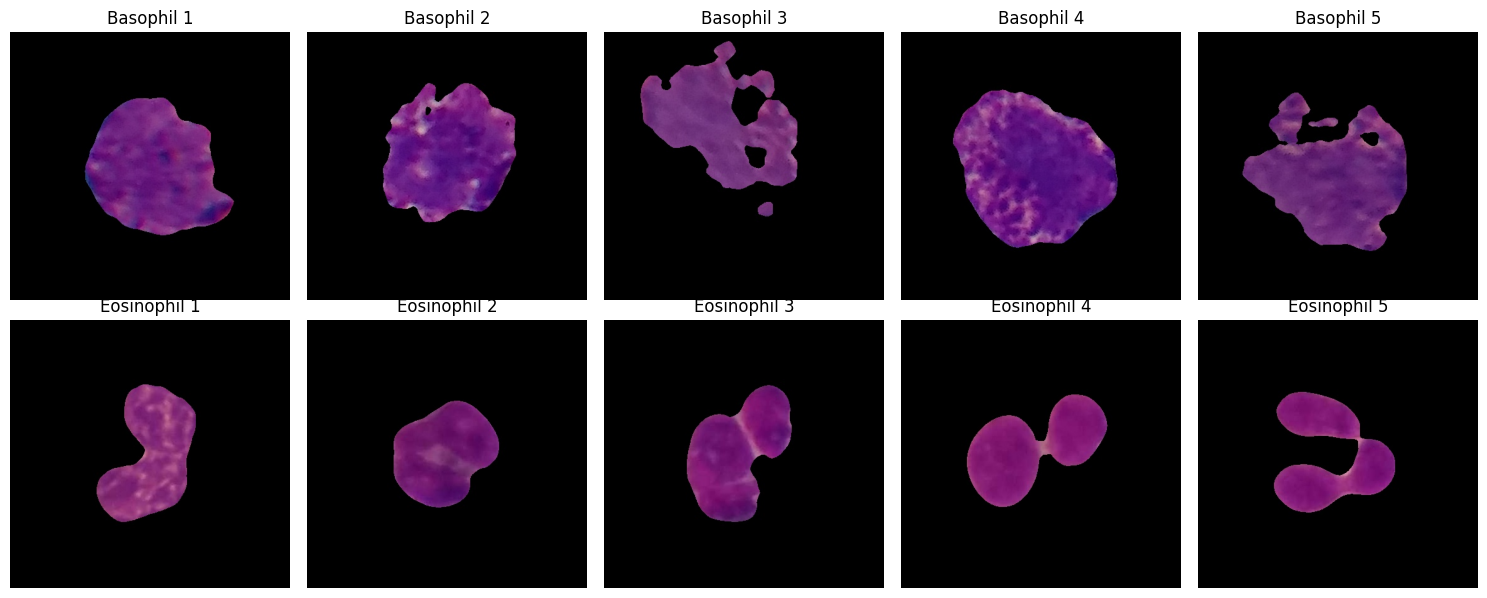


Image dimensions: (446, 428)
Image mode: RGB


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob


basophil_path = '/content/dip_data/Basophil'
eosinophil_path = '/content/dip_data/Eosinophil'

basophil_images = sorted(glob.glob(f'{basophil_path}/*.jpg'))
eosinophil_images = sorted(glob.glob(f'{eosinophil_path}/*.jpg'))

print(f"Number of Basophil images: {len(basophil_images)}")
print(f"Number of Eosinophil images: {len(eosinophil_images)}")


fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Basophil
    img = Image.open(basophil_images[i])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Basophil {i+1}')
    axes[0, i].axis('off')

    # Eosinophil
    img = Image.open(eosinophil_images[i])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Eosinophil {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Check image dimensions
sample_img = Image.open(basophil_images[0])
print(f"\nImage dimensions: {sample_img.size}")
print(f"Image mode: {sample_img.mode}")

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is inc

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_height = 446
img_width = 428
batch_size = 15


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)

all_images = basophil_images + eosinophil_images
all_labels = [0] * len(basophil_images) + [1] * len(eosinophil_images)

from sklearn.model_selection import train_test_split
import pandas as pd


df_images = pd.DataFrame({'filepath': all_images, 'label': all_labels})


train_df, temp_df = train_test_split(df_images, test_size=0.3, random_state=42, stratify=df_images['label'])

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


train_generator_df = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

validation_generator_df = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

test_generator_df = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

from tensorflow.keras import layers, models

# model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(446, 428, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


epochs = 7
history = model.fit(
    train_generator_df,
    steps_per_epoch=train_generator_df.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator_df,
    validation_steps=validation_generator_df.samples // batch_size
)


Found 126 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Training samples: 109
Validation samples: 23
Test samples: 24
Found 109 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 444, 426, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 222, 213, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 220, 211, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 110, 105, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 108, 103, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 54, 51, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 52, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 26, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 79872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │    81,789,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,031,809 (312.93 MB)

 Trainable params: 82,031,809 (312.93 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5626 - loss: 0.7032 - val_accuracy: 0.8667 - val_loss: 0.4069
Epoch 2/7
1/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.8667 - loss: 0.3808

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 797ms/step - accuracy: 0.8667 - loss: 0.3808 - val_accuracy: 0.9333 - val_loss: 0.2437
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 11s/step - accuracy: 0.8866 - loss: 0.3461 - val_accuracy: 0.6667 - val_loss: 1.0969
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.5000 - loss: 2.1593 - val_accuracy: 0.8667 - val_loss: 0.6672
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.9078 - loss: 0.2182 - val_accuracy: 0.8667 - val_loss: 0.1673
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step - accuracy: 1.0000 - loss: 0.1185 - val_accuracy: 1.0000 - val_loss: 0.1460
Epoch 7/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.9483 - loss: 0.2397 - val_accuracy: 1.0000 - val_loss: 0.0724


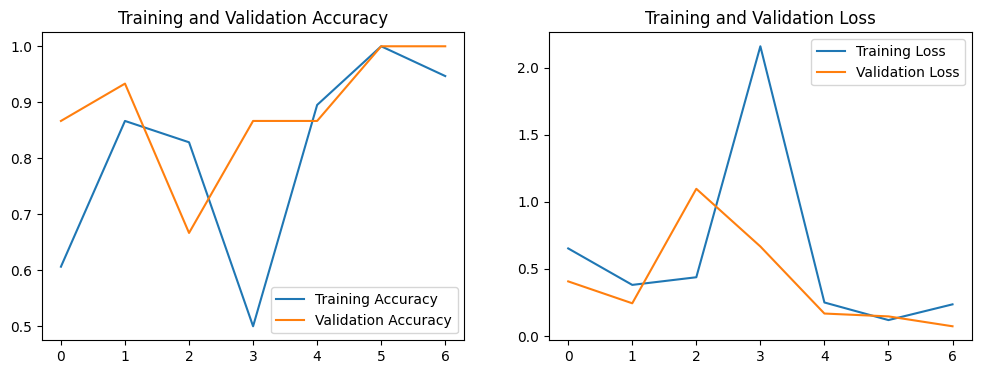

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9333 - loss: 0.2024

Test Loss: 0.2024
Test Accuracy: 0.9333


In [ ]:


import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


test_loss, test_acc = model.evaluate(
    test_generator_df,
    steps=test_generator_df.samples // batch_size
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

class_names = ['Basophil', 'Eosinophil']
target_size = (446, 428)

def predict_images(model, img_paths):
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=target_size)
        arr = image.img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)

        prob = model.predict(arr, verbose=0)[0][0]
        pred_label = 1 if prob >= 0.5 else 0
        conf = prob if pred_label == 1 else 1 - prob
        print(f"{img_path} -> {class_names[pred_label]} (confidence: {conf:.3f})")

# example usage:
predict_images(model, [
    "/content/dip_data/Basophil/Basophil_1.jpg",
    "/content/dip_data/Eosinophil/Eosinophil_1.jpg",
])

/content/dip_data/Basophil/Basophil_1.jpg -> Basophil (confidence: 0.984)
/content/dip_data/Eosinophil/Eosinophil_1.jpg -> Eosinophil (confidence: 0.906)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(446, 428, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dropout(0.80),
    layers.Dense(1024, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

epochs = 7
history = model.fit(
    train_generator_df,
    steps_per_epoch=train_generator_df.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator_df,
    validation_steps=validation_generator_df.samples // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.6635 - loss: 0.8435 - val_accuracy: 0.6000 - val_loss: 0.6021
Epoch 2/7
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.4667 - loss: 0.6696

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.4667 - loss: 0.6696 - val_accuracy: 0.6000 - val_loss: 0.5699
Epoch 3/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.6036 - loss: 0.5567 - val_accuracy: 0.8000 - val_loss: 0.4247
Epoch 4/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 401ms/step - accuracy: 0.9333 - loss: 0.5472 - val_accuracy: 0.9333 - val_loss: 0.3639
Epoch 5/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.9485 - loss: 0.3729 - val_accuracy: 1.0000 - val_loss: 0.0635
Epoch 6/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.9333 - loss: 0.1952 - val_accuracy: 0.9333 - val_loss: 0.2712
Epoch 7/7
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.9691 - loss: 0.1499 - val_accuracy: 1.0000 - val_loss: 0.0280


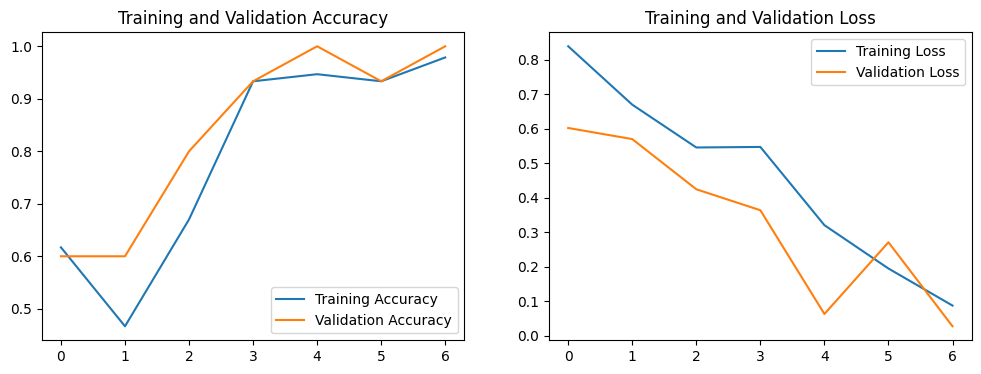

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - loss: 0.9861

Test Loss: 0.9861
Test Accuracy: 0.8667


In [ ]:


import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


test_loss, test_acc = model.evaluate(
    test_generator_df,
    steps=test_generator_df.samples // batch_size
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")